In [1]:
using Symbolics
using LinearAlgebra
using Latexify
using Plots

In [2]:
include("inversion_ext.jl")

#9 (generic function with 1 method)

## Fluídos Conformes

Código para testear la estabilidad alrededor de una solución de equilibrio.

Las ecuaciones son:

$(\zeta^a, \zeta^{ab})$ -> $f^j = (\mu, v, x_i)$ -> $(-1,0,0,0,0)$

$$
\partial_t c^j = \partial_i F^{ij}(f) + I^j(f) = \frac{\partial F^{ij}}{\partial f^k}\partial_i f^k
$$

$$
c^j = C^j(f) = (e, S, c_i)
$$

Lo que hacemos es tomar el jacobiano del flujo,

$\frac{\partial F^i}{\partial f^j}$ donde $f^j$ son las variables no conservativas para las cuales tenemos las expresiones del Flujo. 
A estas las multiplicamos por $[\frac{\partial c^k}{\partial f^j}]^{-1}$.
Tenemos así 

$$
P^{il}{}_j := \frac{\partial F^{il}}{\partial c^j} = \frac{\partial F^{il}}{\partial f^k}\frac{\partial f^k}{\partial c^j}.
$$

Evaluamos todo en el vector $(-1,0,0,0,0)$ o sea estamos en el frame con velocidad cero y todas las variables fuera de equilibrio también cero.

Lo mismo hacemos con la fuente. 

$$
II^i{}_j = \frac{\partial I^i}{\partial f^k} \frac{\partial f^k}{\partial c^j}
$$

Tenemos así el sistema linearizado en el punto de equilibrio en las variables conservativas. Multiplicamos $P^i{}_j$ por un número complejo cualquiera y para todos ellos los autovalores debieran tener parte real negativa o nula. Pero no es así...


Alternativamente podemos diferenciar $c^i$ con respecto a los $f^j$ para obtener,

$$
\partial_t c^j = \frac{\partial c^j}{\partial f^i} \partial_t f^i
$$

y por lo tanto,

$$
\partial_t f^i = \frac{\partial c^j}{\partial f^i}^{-1} \frac{\partial F^{lj}}{\partial f^k}\partial_l f^k := \tilde{P}^i{}_k\partial_l f^k
$$

A las que simplemente sumamos el término $\frac{\partial c^j}{\partial f^i}^{-1}\frac{\partial I^j}{\partial f^k}$ para tener el sistema linearizado con respecto a las $f^i$.


Sistema mixto, supongamos ahora que tenemos el sistema escrito como:

$$
\frac{\partial c^i}{\partial t} = \partial_x Fl^i(f^k(c^j), c^k) = 
\frac{\partial Fl^i}{\partial c^k} \partial_x c^k 
+ \frac{\partial Fl^i}{\partial f^l} \frac{\partial f^l}{\partial c^k} \partial_x c^k
= (\frac{\partial Fl^i}{\partial c^k}  
+ \frac{\partial Fl^i}{\partial f^l} \frac{\partial f^l}{\partial c^k}) \partial_x c^k
$$

In [3]:
function Flux_imp!(Fl,flu,con,p)
    χ = p
    μ = flu[1]  # esto es -μ
    #μ = view(flu,1)
    T = (abs(μ))^(-1//2) # use μ positive, so I changed μ -> -μ
    v = flu[2]
    ν = flu[3]
    r1 = flu[4]
    t11 = flu[5]
    χ₀ = χ[1]
    χ₁ = χ[2]
    χ₂ = χ[3]
    γ = (1 - v^2)^(-1//2)
    T11_0 = -8χ₀*T^4*(γ^2*v^2+1/4)
    T11_1 = χ₁*(-80//3*T^8*ν*(γ^2*v^2+1)  - 20*T^7*r1*γ*v  - 2*T^6*t11)
    T11_2 = χ₂*T^8*(ν^2*(-560*T^4*(γ^2*v^2 + 1//4)) - ν*r1*T^3*1120*γ*v - ν*t11*T^2*112
                    + r1^2*T^2*(-315v^2-217)
                    + r1*t11*T*336*γ*v*(v^2-1)
                    + t11^2*(-111 - 78v^2 + 189v^4)/4)
    Fl[1] = con[2]
    Fl[2] = T11_0 + T11_1 + T11_2
    Fl[3] = con[4]
    Fl[4] = con[5]
    Fl[5] = -3χ₁*γ*v*T^5*(2γ^2*v^2+1) - 12χ₂*(v*T*10*γ*(2γ^2*v^2+1)*ν + 3*(1+6γ^2*v^2)*r1 + 3v*γ*t11/T)
    return -Fl[:]
end



Flux_imp! (generic function with 1 method)

In [4]:
@variables f[1:5], c[1:5], Fl[1:5], p[1:3], r[1:5]

JFS_f = Symbolics.jacobian(Flux_imp!(Fl,f,c,p),f);
JFS_c = Symbolics.jacobian(Flux_imp!(Fl,f,c,p),c);
JF_f_exp = Symbolics.build_function(JFS_f, Fl, f, c, p);
JF_c_exp = Symbolics.build_function(JFS_c, Fl, f, c, p);
JFac_f = eval(JF_f_exp[1]);
JFac_c = eval(JF_c_exp[1]);
#JF_f_exp[2]

In [42]:
re = zeros(5)
fl = zeros(5)
flu=[-1.;0.9;0;0;0];
par_f = [-1.,-0.1,0.06]
con = F_alt!(re,flu,zeros(5), par_f);
JFac_f(fl,flu,con,par_f)
JFac_c(fl,flu,con,par_f)
inv(Jac_alt(r,flu,con,par_f)) # Notar que para v \to 1 la matríz se hace singular.

5×5 Matrix{Float64}:
  0.203095     -0.201973       0.129426  -0.245193    0.115839
 -0.0383749     0.0406134     -0.024455   0.047891   -0.0232934
  0.0211557    -0.0210389     -1.214      2.46166    -1.25028
 -0.0643552     0.0681093      4.59241   -9.67576     5.08074
 -1.42109e-14   1.42109e-14  -20.7495    46.9825    -26.337

In [6]:
#include("inversion_ext.jl");
#println(F_alt!([0.;0.;0.;0.;0.],[-1;0.2;3;4;5],[6;7;8;9;10],[1;2;3]))


In [7]:
P(r,fl,flu,c,p) =  JFac_f(fl,flu,con,p)*inv(Jac_alt(r,flu,con,p)) + JFac_c(fl,con,flu,p) #var conserv
PT(r,fl,flu,c,p) = inv(Jac_alt(r,flu,con,p))*(JFac_f(fl,flu,con,p) + JFac_c(fl,con,flu,p)*Jac_alt(r,flu,con,p)) #var fluid

PT (generic function with 1 method)

In [35]:
re = zeros(5)
fl = zeros(5)
flu=[-1.;0.;0;0;0.];
par_f = [1.,-0.1,0.06]
con = F_alt!(re,flu,zeros(5), par_f);
H = [3/2 0 0 0 0;
     0 2 0 0 0;
     0 0 2 0 0;
     0 0 0 3/2 0;
     0 0 0 0 0.3/1.3333333]*PT(re,fl,flu,c,par_f)

5×5 Matrix{Float64}:
  0.0  -1.0         0.0       -4.09959e-18   0.0
 -1.0   0.0         0.508834   0.0          -4.77827e-18
  0.0   0.0         0.0       -1.0           0.0
  0.0   0.0        -0.946996   0.0          -0.3
  0.0   0.0416667   0.0       -0.3           0.0

In [31]:
H = [3/2 0 0 0 0;
     0 2 0 0 0;
     0 0 2 0 0;
     0 0 0 3/2 0;
     0 0 0 0 0.3/1.3333333]
H*PT(re,fl,flu,c,par_f)

5×5 Matrix{Float64}:
  0.0  -1.0       0.0       0.0   0.0
 -1.0   0.0       0.49974   0.0   0.0
  0.0   0.0       0.0      -1.0   0.0
  0.0   0.0      -1.00156   0.0  -0.3
  0.0  -0.00125   0.0      -0.3   0.0

In [10]:
re = zeros(5)
fl = zeros(5)
flu=[-1.;0.1;0.01;0.01;0.01];
par_f = [-1.,-10.,2.]
con = F_alt!(re,flu,zeros(5), par_f);
eigvals(P(re,fl,flu,con,par_f))

5-element Vector{Float64}:
 -1.1033519382756454
 -0.8051097728991515
 -0.09975976592248087
  0.7223309130757883
  1.1476503457167198

In [11]:
re = zeros(5)
fl = zeros(5)
flu=[-1.;0.0;0.;0.0;0.];
par_f = [1.,-1.,2.]
con = F_alt!(re,flu,zeros(5), par_f);
eigvals(PT(re,fl,flu,con,par_f))

5-element Vector{Float64}:
 -0.7745966692414838
 -0.5276251305503544
  2.6712558542924714e-16
  0.5276251305503545
  0.7745966692414831

In [12]:
re = zeros(5)
fl = zeros(5)
N = 1000
flu=[-1.;0.0;0.1;0.01;0.001];
par_f = [1.,-1.,-0.06]
#par_f = [-1,-0.5,-20]
E = zeros(5,N)
v = zeros(N)
for i in 1:N
    v[i] = (i-1)/(N-1)/1.01
    flu[2] = v[i]
    re = zeros(5)
    fl = zeros(5)
    con = F_alt!(zeros(5),flu,zeros(5), par_f);
    E[:,i]=eigvals(P(zeros(5),zeros(5),flu,con,par_f))
    if any(E[:,i].>1.)
        #println(E[:,i], v[i])
    end
end

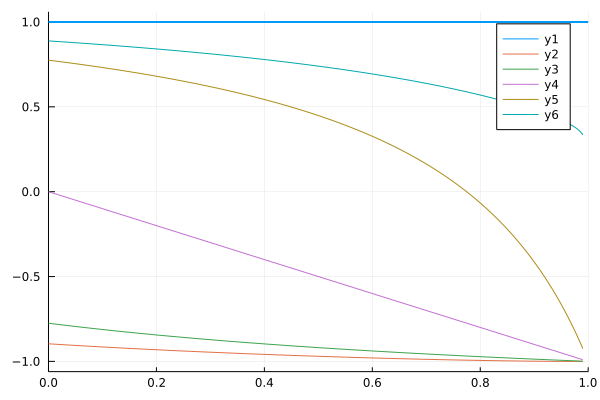

In [13]:
one(x)=1
plot(one,xlim=(0,1),legend=:topright, lw=2)
plot!(v,E[1,:])
plot!(v,E[2,:]
#,legend=:topright
)
plot!(v,E[3,:])
plot!(v,E[4,:])
plot!(v,E[5,:])

In [14]:
Eu(flu,con,par_f) = P(re,fl,flu,con,par_f)[1:2,1:2]

Eu (generic function with 1 method)

In [15]:
N = 100
par_f = [-1.,-0.01,-0.001]
Eul = zeros(2,N)
flu = [-1; 0; 0.1; 0.0; 0.0]
for i in 1:N
    v = (i-1)/N
    flu[2] = v
    re = zeros(5)
    con = F_alt!(re,flu,zeros(5), par_f);
    #Eul[:,i]=eigvals(Eu(flu,[con[1];con[2];0;0;0],par_f))
    Eul[:,i]=eigvals(Eu(flu,con,par_f))
end

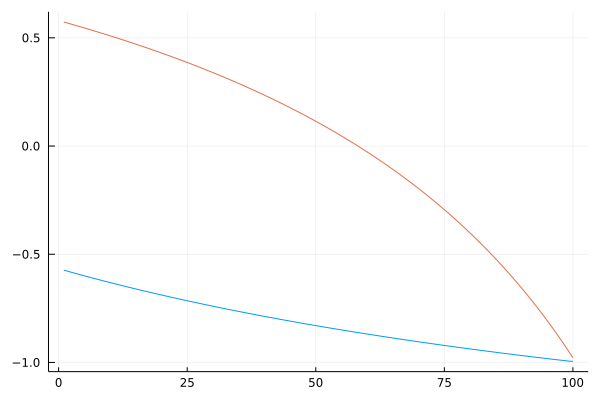

In [16]:
plot(Eul[1,:],
    label=false)
plot!(Eul[2,:],
    label=false)

## Hacemos lo mismo para la fuente.

In [17]:
function Is(flu, χ, ξ)
    #(χ, ξ) = par 
    μ = flu[1] 
    #χ₀= χ[1]
    #χ₁= -χ[2] # lo hacemos positivo
    #κ = ξ[1]*χ₀ # χ₀*ξ[1]/χ₁^2 # OK 
    #λ = ξ[2]*χ₀ #χ₀*ξ[2]/χ₁^2  # OK
    #η = ξ[3]*χ₀ #χ₀*ξ[3]/χ₁^2
    T = (abs(μ))^(-1//2) # use μ positive, so I changed μ -> -μ
    v = flu[2]
    γ = (1. - v^2)^(-1//2)
    x1 = γ*T*flu[3]
    x2 = flu[4]
    x3 = γ/T*flu[5]
    return [0.;
            0.;
            (-(γ^2    -1//4)*x1*ξ[1]         + 2γ*v*x2*ξ[2]/T      - μ*v^2*x3*ξ[3])/μ^5;
            (-(γ^2*v  + 0  )*x1*ξ[1]         + γ*(v^2+1)*x2*ξ[2]/T - μ*v*x3*ξ[3])/μ^5;
            (-(γ^2*v^2+1//4)*x1*ξ[1]         + 2γ*v*x2*ξ[2]/T      - μ*x3*ξ[3])/μ^5;
            ]
end

Is (generic function with 1 method)

In [18]:
@variables q[1:3]  
Is(f,p,q);

In [19]:
JSS = Symbolics.jacobian(Is(f,p,q),f);

In [20]:
JS_exp = Symbolics.build_function(JSS, f, p,q);

In [21]:
JSac = eval(JS_exp[1]);

In [22]:
II(r,flu,con,p,q) = JSac(flu,p,q)*inv(Jac_alt(r,flu,con,p))

II (generic function with 1 method)

In [88]:
flu=[-1.;0.0;0.0;0.0;0.00];
par_f = [1.,-1.,-0.06]
par_f = #[-1,-1,-20.]
con = F_alt!(zeros(5),flu,zeros(5), par_f);
par_s = 100π*[-10; -15; -1]
eigvals(II(zeros(5),flu,con,par_f,par_s))

5-element Vector{Float64}:
 -26.179938779914945
  -8.726646259971648
   0.0
   0.0
   6.544984694978737

In [87]:
flu=[-1.;0.0;0.0;0.0;0.00];
par_f = [1.,-1.,-0.06]
par_f = #[-1,-1,-20.]
con = F_alt!(zeros(5),flu,zeros(5), par_f);
par_s = -100π*[-10; -15; -1]
eigvals(II(zeros(5),flu,con,par_f,par_s))

5-element Vector{Float64}:
 -6.544984694978737
  0.0
  0.0
  8.726646259971648
 26.179938779914945

In [104]:
N = 100
flu=[-1.;0.0;0.0;0.0;0.00];
par_f = [1.,-1.,-0.06]
par_f = #[-1,-1,-20.]
par_s = 100π*[-10; +15; +1] #[-1/15/π, 1/π, -1/π] #(κ,λ,η)
ET = fill(1.0+0*im,5,N)
v = zeros(N)
for i in 1:N
    v[i] = (i-1)/N/1
    flu=[-1.;0.0;0.0;0.0;0.00];
    flu[2] = v[i]
    con = F_alt!(zeros(5),flu,zeros(5), par_f);
    ET[:,i]=eigvals(0.0*im * P(zeros(5),fl,flu,con,par_f) - 1.0*II(zeros(5),flu,con,par_f,par_s))
#    if any(imag.(ET[:,i]).>1.)
        #println(imag.(ET[:,i]), v[i])
#    end
#    if any(real.(ET[:,i]).>0.)
        #println(real.(ET[:,i]), v[i])
#    end
end
par_s

3-element Vector{Float64}:
 -3141.5926535897934
  4712.38898038469
   314.1592653589793

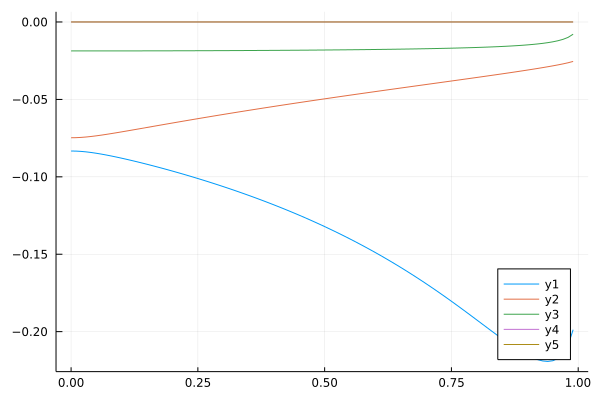

In [105]:
plot(legend=:bottomright)
for i in 1:5
    plot!(v,real.(ET[i,:])
        #,ylims=(-0.01,0.001)
    )
end
current()

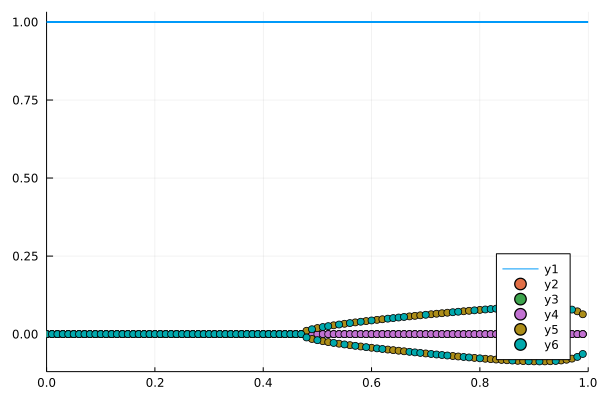

In [25]:
#one(x)=1
plot(one,xlim=(0,1),legend=:bottomright, lw=2)
for i in 1:5
    scatter!(v,imag.(ET[i,:]))
end
current()

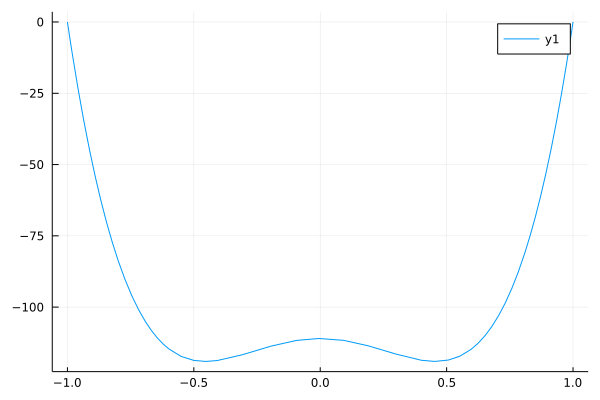

In [26]:
# el término enfrente de t11^2 Notar que va a cero cuando v \to \pm 1
lt11_2(vv)=(-111 + 126vv^2 - 15vv^4 - 204vv^2*(1-vv^2))#/(1-vv^2)
plot(lt11_2, -1,1)

In [27]:
lr1_2(vv) = -364*vv^2-217+49vv^2
plot(lr1,-1,1)

LoadError: UndefVarError: lr1 not defined

$$
\frac{\partial^3 \chi}{\partial \zeta^a \partial \zeta^A \partial \zeta^B}\nabla_a \zeta^B = I^{A}
$$

$$
\nabla_a(\frac{\partial^2 \chi}{\partial \zeta^a \partial \zeta^A}) = I^A
$$